## The power of the graph perspective in clustering

#### Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from scipy.linalg import svd
from scipy.spatial import distance
from sklearn.preprocessing import normalize

#### Helper Functions

In [ ]:
def get_data(n_samples, seed):
    T_matrix = [[-0.60834549, -0.63667341], [0.40887718, 0.85253229]]
    #X: A numpy array of feature points (coordinates) in 2D space
    #y: A numpy array of integer labels indicating which cluster each point belongs to originally
    X_orig, y_orig = make_blobs(n_samples=n_samples, random_state=170) # Generates a default number of centers (typically 3)
    X = np.dot(X_orig, T_matrix)
    return X

In [3]:
def show_data_results(X, y_pred=None, cmap='jet'):
    if y_pred is None:
        plt.scatter(X[:, 0], X[:, 1])
        plt.title ("input data")
    else:
        fig = plt.figure(figsize=(10, 3))
        ax1 = fig.add_subplot(121)
        ax1.scatter(X[:, 0], X[:, 1])
        ax1.set(xticks=[],yticks=[],title ="input data")

        ax2 = fig.add_subplot(122)
        ax2.scatter(X[:, 0], X[:, 1], c=y_pred, cmap=cmap)
        ax2.set(xticks=[], yticks=[], title ="clustered data")

# K-Means Clustering

Please, read https://en.wikipedia.org/wiki/K-means_clustering about the Kmeans algorithm.

In this problem, we will show how interperting a dataset as a graph may result is obtaining an elegant clustering solution. We have an input dataset that we wish to cluster in 3 aparant classes. 

We provide the synthetic dataset of 2000 points described below where the T_matrix is just a 2D transformation matrix:

In [4]:
n_samples, seed = 2000, 170
X = get_data(n_samples, seed)

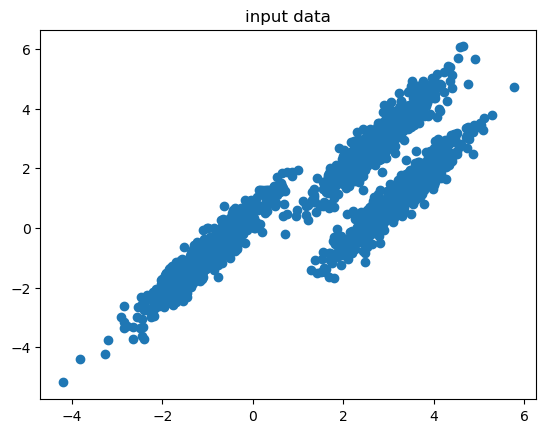

In [5]:
show_data_results(X)

Using the the Kmeans algorithm implementation of sklearn, show your attempt to cluster this dataset into 3 classes in one luine of code.

In [6]:
y_pred = KMeans(n_clusters=3, random_state=seed).fit_predict(X)

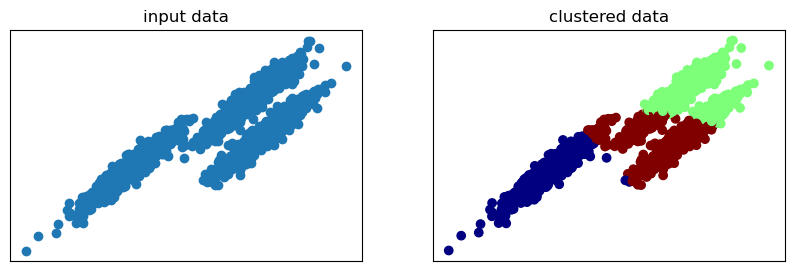

In [7]:
show_data_results(X, y_pred)

## Q.1.

Comment on the output the the KMeans algorithm? Did it work? If so explain why, if not, explain why not.

* The K-means algorithm did not work effectively for this dataset. Looking at the clustered data (right plot), K-means has divided the data into three clusters, but these clusters don't properly capture the natural structure of the data(three elongated, curved branches).
* K-means assumes clusters are spherical and similar in size, uses Euclidean distance as its similarity metric.
* In this dataset, points that belong to the same natural cluster might be far apart in Euclidean distance.

## Q.2.

Let's now interprete every single point in the provided dataset as a node in a graph. Our goal is to find a way to relate every node in the graph is such way that they points that closer together maintain that relationship while points that are far are explicitely identified. 

lots of points points are closed top each other and kmaeans is missing it. representing as the graph unveils the relation.

One way to capture such relationship between points (nodes) in a graph is through the Adjacency matrix. Typically, a simple adjacency matrix between nodes of and indiredted graph is given by:

$$A_{i, j}=\begin{equation}
\left\{ 
  \begin{aligned}
    1: \text{if there is an edge between node i and node j}, \\
    0: \text{otherwise.}\\
  \end{aligned}
  \right.
\end{equation}
$$

In this probem, we will use the weighted distances betweeen points instead as a similary measure. Write a function that takes in the input dataset and some coeficient gamma which returns the adjacency matrix A.

$$A_{i, j} = e^{\gamma {||x_{i}-x_{j}||^2}}$$ 

where $x_{i}$ and $x_{j}$ represent each point in the provided dataset. You may find the `distance` module from `scipy.spatial` useful.

In [8]:
def get_adjacency_matrix(gamma, X):
    adjacency_matrix = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            adjacency_matrix[i, j] = np.exp(-gamma * np.linalg.norm(X[i] - X[j]) ** 2)
    return adjacency_matrix

## Q. 3.

The degree matrix of an undirected graph is a diagonal matrix which contains information about the degree of each vertex. In other word, it contains the number of edges attached to each vertex and it is given by:

$$D_{i, j}=\begin{equation}
\left\{ 
  \begin{aligned}
    deg(v_{i}): \text{if i == j}, \\
    0: \text{otherwise.}\\
  \end{aligned}
  \right.
\end{equation}
$$

where the degree $ {\deg(v_{i})}$ of a vertex counts the number of times an edge terminates at that vertex. Note that in the traditional definition of the adjacency matrix, this boils down to the diagonal matrix in which element along the diagonals are column-wise sum of the adjacency matrix. Using the same idea, write a function that takes in the adjacency matrix as argument and `returns the inverse square root of degree matrix`.


In [11]:
def get_degree_matrix(adjacency_matrix):
    # TODO: fill in your code here
    # degree_matrix = ?
    degrees = np.sum(adjacency_matrix, axis=1)
    # create a empty matrix with the same size as the adjacency matrix
    n = adjacency_matrix.shape[0]
    degree_matrix = np.zeros((n, n))
    
    epsilon = 1e-10 
    for i in range(n):
        degree_matrix[i,i] = 1.0 / np.sqrt(degrees[i] + epsilon)
    return degree_matrix

## Q. 4.

Using $\gamma$ = 7.5, compute the symmetrically normalized adjacency matrix A, degree matrix D and the matrix $M = D^{-1/2} A D^{-1/2}$

In [14]:
# adjacency_matrix = ?
# degree_matrix = ?
# M = ?
gamma = 7.5
A = get_adjacency_matrix(gamma, X)
D = get_degree_matrix(A)
M = np.dot(np.dot(D, A), D)

## Q. 5.

Using SVD decomposition, write a function that select the first 3 vectors in the matrix U and perform the same KMeans clustering used above to cluster them them. What do you observe? Did it work? If so explain why, if not, explain not not.

In [19]:
def cluster_data(M, first_n_vectors):
    '''
    Perform spectral clustering using SVD decomposition
    '''
    # deompose M into U, S, V
    U, S, Vt = svd(M)

    # select the first 3 vectors in the matrix U
    U_reduced = U[:, :first_n_vectors] #(n, 3)

    # Step 3: Apply K-means clustering on the reduced representation
    y_pred = KMeans(n_clusters=3, random_state=seed).fit_predict(U_reduced)

    return U_reduced, y_pred

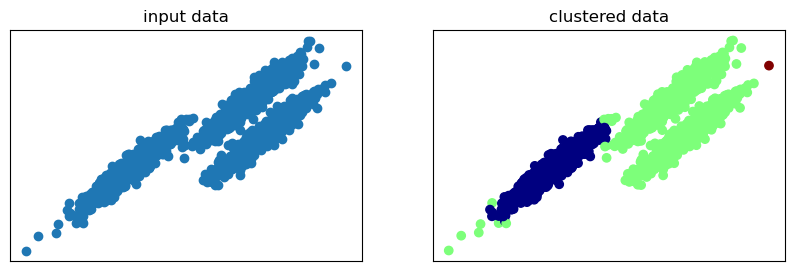

In [20]:
U_reduced, y_pred = cluster_data(M, 3)
show_data_results(X, y_pred)

## Q.6. 

Now lets think of the Adjacency obtained above as the transition Matrix in of a Markov Chain.To do so,$A$ needs to be a proper stochastic matrix which means that:
1. the sum of the element in each column must add up to 1. 

Write a function that takes in the matrix M and returns $M_{stachastic}$, the stochastic version of M; compute the stochastic matrix

In [21]:
def stochastic_matrix_converter(M):
    """
    Convert matrix M to a column-stochastic matrix where each column sums to 1
    """
    # TODO: fill in your code here
    # degree_matrix = ?
    col_sums  = np.sum(M, axis=0)
    epsilon = 1e-10
    M_stoch = M / (col_sums + epsilon)
    return M_stoch

In [22]:
M_stoch = stochastic_matrix_converter(M)

perform the same KMeans clustering used above the resulting top 3 U vectors and plot your answers

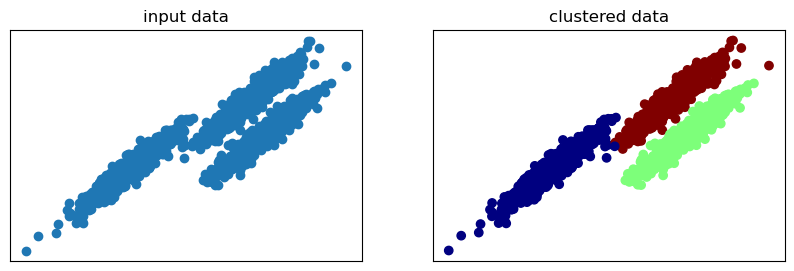

In [23]:
y_pred_spectral_stoch = cluster_data(M_stoch, 3)[1]
show_data_results(X, y_pred_spectral_stoch)

## Q.7. 

Now, let's investigate how we could have made the matrix $M$ work directly in our original interpretation. To do this, normalize those 3 vectors before performing the clustering. 
 **Show the plots. What do you observe? Did it work? If so, explain why normalizing the vectors gives what is expecte**.

In [ ]:
def cluster_data_normalized(M, k):
    '''
    Perform spectral clustering using normalized vectors
    '''
    # decompose M into U, S, V
    U, S, Vt = svd(M)
    # select the top k vectors in the matrix U
    eigenvectors = U[:, :k]
    # normalize the eigenvectors
    row_norms = np.linalg.norm(eigenvectors, axis=1, keepdims=True)
    eigenvectors_normalized = eigenvectors / (row_norms + 1e-10)

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(eigenvectors_normalized)
    
    return eigenvectors_normalized, labels

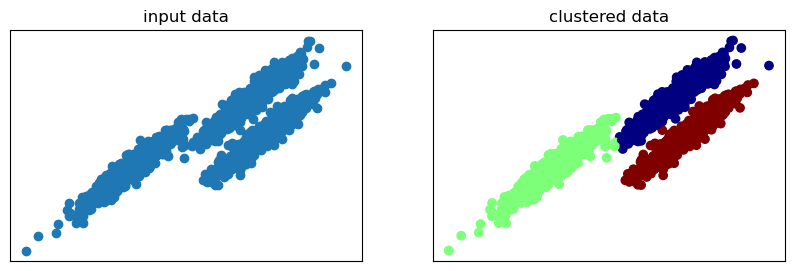

In [29]:
embedding_normalized, y_pred_normalized = cluster_data_normalized(M, 3)
show_data_results(X, y_pred_normalized)